<h1><center> Edge Effects in Galaxy Surveys : A Tutorial </center></h1>

<h2><center>Author: Nitya Mandyam (__[nmd299@nyu.edu](nmd299@nyu.edu)__)</center></h2>
<h3><center> Centre for Cosmology and Particle Physics, NYU</center></h3>

<p> <b><i> How does the fact that a galaxy might be at the edge of a survey mask affect the measurement of its environments?</i> <br>
    <i>How can we effectively identify and remove such galaxies? </i></b></p>
            
<p> <i>What is an angular mask?: </i> <br>
Galaxy surveys cover limited regions of the sky. Typically the area of coverage of a survey in the RA-Dec (angular co-ordinates!) space is referred to as a survey mask or an angular mask.  </p>

<p> <i>What are "environments"?: </i> <br>
Simplistically, a "galaxy environment" refers to the density of galaxies in the region where a galaxy is "located". Here, we are simply going to count the number of galaxies around any galaxy within a projected aperture of 0.5 Mpc using k-dtrees.
 </p>

In [ ]:
#Relevant Packages

#Basic
import numpy as np
import sys
import os

#Packages to deal with .fits files;
#Pickling is great for intermediate data storage
import pyfits
import pickle

# To measure Environments(number of neighbours!) 
# of galaxies, we are going to use kd-trees
import scipy
import scipy.spatial as ss

#Plotting packages
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

In [5]:
# Some plotting preferences.
# rcParams["font.size"] = 16
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['figure.titlesize'] = 1

In [9]:
#Importing the angular mask
os.chdir('/Users/nitya/Work/Data/Project1/edge_effects')
print(os.getcwd())

d = pyfits.open("lss_combmask.dr72.fits")
d = d[1].data
print(d.columns)
fg= d['fgotmain']
ind0 = np.where(fg==0)[0]
ind1 = np.where(fg==1.0)[0]
print(len(fg[ind0]), len(fg[ind1]))

/Users/nitya/Work/Data/Project1/edge_effects
ColDefs(
    name = 'XCAPS'; format = '42D'; dim = '( 3, 14)'
    name = 'CMCAPS'; format = '14D'
    name = 'NCAPS'; format = 'J'
    name = 'WEIGHT'; format = 'D'
    name = 'STR'; format = 'D'
    name = 'USE_CAPS'; format = 'J'; bscale = 1; bzero = 2147483648
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'SECTOR'; format = 'J'
    name = 'MMAX'; format = 'E'
    name = 'DIFFRUN'; format = 'J'
    name = 'ITILING_GEOMETRY'; format = 'J'
    name = 'ITARGET_GEOMETRY'; format = 'J'
    name = 'ILSS'; format = 'J'
    name = 'FGOTMAIN'; format = 'E'
)
6803 66656


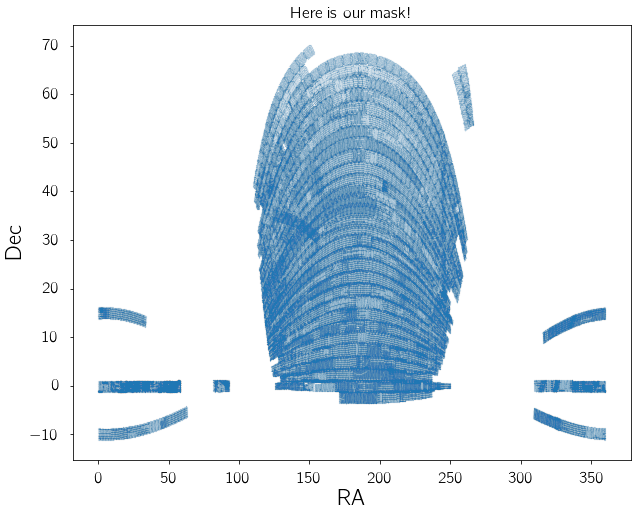

In [41]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(d['RA'],d['DEC'], s = 0.001)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Here is our mask!')
plt.show()

In [10]:
# Importing the Data.
os.chdir('/Users/nitya/Work/Data/Project1/measurements')

file2 = open(r'SFRP.pkl','rb')
d2 = pickle.load(file2, encoding ='latin1')
file2.close()

file3 = open(r'EDP.pkl','rb')
d3 = pickle.load(file3, encoding ='latin1')
file3.close()

<h2> 1. Visualizing the raw data: </h2>
What our sample looks like before edge correction.

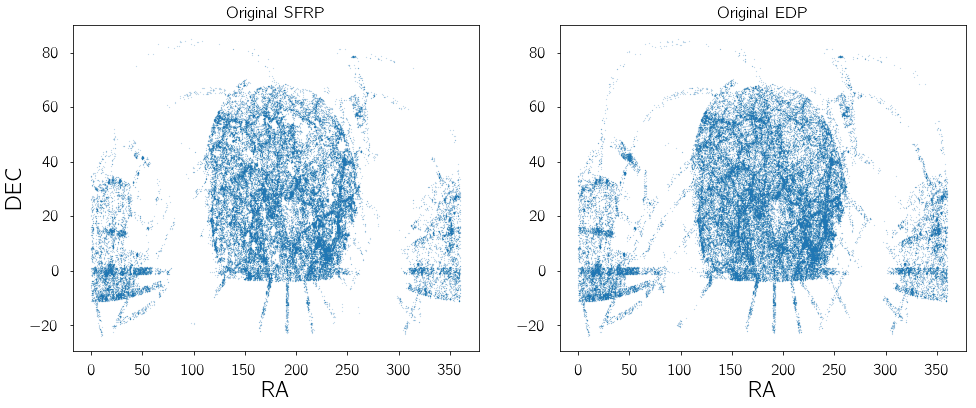

In [11]:
ra = np.asarray(d2['RA'])
dec = np.asarray(d2['DEC'])
nsa = np.asarray(d2['NSAID'])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (16,6))
ax1.scatter(ra,dec, s = 0.01)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_title('Original SFRP')


ra2 = np.asarray(d3['RA'])
dec2 = np.asarray(d3['DEC'])
nsa2 = np.asarray(d3['NSAID'])
ax2.scatter(ra2,dec2, s = 0.01)
ax2.set_xlabel('RA')
ax2.set_title('Original EDP')
plt.show()

<h2> 2. Data Munging </h2>

1. Munging the data to a smaller, more manageable dataset; The only values we need are RA and Dec.
2. Removing obvious outliers:  Sometimes, like here, there maybe galaxies in the catalogue that are not even part of the survey mask..(combmask here!); we are going to identify and remove these obvious outliers first!

In [12]:
Data munging
SFR RA Dec file
stuff1 = np.column_stack((ra,dec))
filename = 'sfr_ra_dec'
f = open(filename,'w')
for line in stuff1:
    f.write("  ".join(str(x) for x in line) + "\n")
f.close()

#EDP RA Dec File
stuff2 = np.column_stack((ra2,dec2))
filename = 'edp_ra_dec'
f = open(filename,'w')
for line in stuff2:
    f.write("  ".join(str(x) for x in line) + "\n")
f.close()


1. The combmask polygon file was pixelized and snapped and polyid.sh was run to determine whether or not said galaxy (within EDP/SFRP) was within one of these polygons.
2. Effectively this removed the SEGUE galaxies (among other things) and reduced our SFRP and EDP sizes to 62991 and 75476 respectively;
3. Setting fgotmain to > 0.8 leaves us with 62317 galaxies in SFRP and 77307 in EDP;


In [13]:
os.chdir('/Users/nitya/Work/Data/Project1/edge_effects/')
print(os.getcwd())

# Reading the polygon file!
w = open('sfr_polyid_0', 'r')
u = np.asarray(w.readlines())
print(u[0])
v = np.array([np.array(u[1:][i].split(), dtype = float) for i in range(len(u[1:]))])

rap = np.asarray([v[i][0] for i in range(len(v))])
decp = np.asarray([v[i][1] for i in range(len(v))])
lens = np.asarray([len(v[i]) for i in range(len(v))])

i1 = np.where(lens==3)[0]
i2 = np.where(lens==2)[0]
print(len(v))
print(len(v[i1]))
print(len(v[i2]))

#NEW SFRP
b2 = d2[i1]
afile = open(r'SFRTP.pkl', 'wb')
pickle.dump(b2, afile)
afile.close()

#polygons
p_sfr = np.asarray([v[i1][i][2] for i in range(len(v[i1]))])

#EDP stuff
f = open('edp_polyid_0', 'r')
g = np.asarray(f.readlines())
print(g[0])
h = np.array([np.array(g[1:][i].split(), dtype = float) for i in range(len(g[1:]))])

raq = np.asarray([h[i][0] for i in range(len(h))])
decq = np.asarray([h[i][1] for i in range(len(h))])
lens2 = np.asarray([len(h[i]) for i in range(len(h))])
print(lens2)

j1 = np.where(lens2==3)[0]
j2 = np.where(lens2==2)[0]
print(len(h))
print(len(h[j1]))
print(len(h[j2]))
b3 = d3[j1]
afile = open(r'ETP.pkl', 'wb')
pickle.dump(b3, afile)
afile.close()
#polygons
p_edp = np.asarray([h[j1][i][2] for i in range(len(h[j1]))])


/Users/nitya/Work/Data/Project1/edge_effects
      az(d)       el(d) polygon_ids

75476
62991
12484
      az(d)       el(d) polygon_ids

[2 3 3 ... 3 3 3]
95638
78174
17463


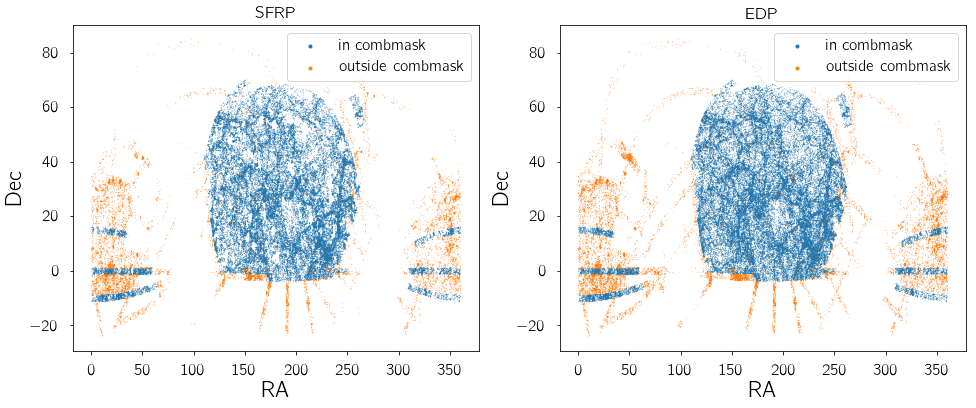

In [14]:
#Plotting the results

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16,6))
ax1.scatter(rap[i1], decp[i1], s = 0.01, label = 'in combmask')
ax1.scatter(rap[i2], decp[i2], s = 0.01, label = 'outside combmask')
ax1.set_xlabel('RA')
ax1.set_ylabel('Dec')
ax1.set_title('SFRP')
ax1.legend(loc = 1, markerscale = 30)
#plt.savefig('new_sfrp.pdf')

ax2.scatter(raq[j1], decq[j1], s = 0.01, label = 'in combmask')
ax2.scatter(raq[j2], decq[j2], s = 0.01, label = 'outside combmask')
ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')
ax2.set_title('EDP')
lgnd = plt.legend(loc = 1, markerscale = 30)
#plt.savefig('new_edp.pdf')
plt.show()

In [27]:
#Checking if the RA-Dec's match up;

indices = [np.int(p_edp[i]) for i in range(len(p_edp))]
indices2 = [np.int(p_sfr[i]) for i in range(len(p_sfr))]

good = np.where(fg[indices]> 0.8)[0]
odd = np.where(fg[indices]<=0.8)[0]
good2 = np.where(fg[indices2]>0.8)[0]
odd2 = np.where(fg[indices2]<=0.8)[0]
c2 = b2[good2]
c3 = b3[good]

print(len(c2),len(c3))

62317 77307


<h2> 3. Environments </h2>


In [25]:
#On a unit sphere:

def coords(ra,dec):
        radius = 1.0
        
        x = radius*np.cos(dec*np.pi/180.0)*np.cos(ra*np.pi/180.0)
        y = radius*np.cos(dec*np.pi/180.0)*np.sin(ra*np.pi/180.0)
        zed = radius*np.sin(dec*np.pi/180.0)
        return x,y,zed

#x, y, zed = coords(ra_r,dec_r)


def kdtree(x,y,zed):
    points = np.column_stack((x,y,zed))
    tree = ss.KDTree(points)
    sample_x, sample_y, sample_z = coords(ra,dec)
    sample = np.column_stack((sample_x,sample_y, sample_z))
    ns = [tree.query_ball_point(sample[i],t[i]) for i in range(len(t))]
    nc = np.asarray([len(ns[i]) for i in range(len(ns))])
    id_count = np.column_stack((nsaid,nc))
    return(ns,nc, id_count)

<h2> 4. Populating the Mask with random points </h2>


Galaxies at the Survey Edge: (Our sample, S has 77307 galaxies)

1. We first populate our polygons with N = 1,000,000 random galaxies; (So we have sample B of 1,000,000 points in this projected-2D-plane?)

2. For R_aperture/"transverse linking length" r, find out what the corresponding angular separation t is for each galaxy is S;

3. For each galaxy in S, we need to count number of galaxies in B within t and then look at the distribution of t and obviously the edges will pop out in the lower end;





Before going any further and defining this as our EDP for real, let's set a lower bound for z...:

In [ ]:
os.chdir('/Users/nitya/Work/Data/Project1/measurements/')
import pandas as pd

w = pd.read_csv('ransacked_100M', header = None, sep = '\t')
ra_r = w.iloc[:,0].values
dec_r = w.iloc[:,1].values

#Aperture size = 0.5 Mpc; c3: EDP array; 
r = 0.5
z = np.asarray(c3['Z'])
print(np.min(z),np.max(z),np.median(z))
low_z = np.where(z<=0.0015)[0]
sampl = np.where(z>0.0015)[0]
print(len(z[low_z]))

In [28]:
d3 = c3[sampl]
nsaid = np.asarray(c3['NSAID'][sampl])
ra = np.asarray(c3['RA'][sampl])
dec = np.asarray(c3['DEC'][sampl])
z = np.asarray(c3['Z'][sampl])
dist = np.array([WMAP7.comoving_distance(z[i]).value for i in range(len(z))])
#theta

t = np.asarray([r/dist[i] for i in range(len(dist))])
print(np.min(t),np.max(t))


#Call the environments now! It should take you about 5 seconds per galaxy on an average;
#I have pickled them separately with their ID counts. And so I'm going to go ahead and load that.

-0.00026992484 0.055001467 0.042439453
14
0.0021593187697978803 0.06986514236936234


<h2> 5. Identifying the edges! </h2>

With a mask with 100 million points, it is dense enough that the environments should match up their expectation values... If they don't, you have found an "edge galaxy!"

In [30]:
os.chdir('/Users/nitya/Work/Data/Project1/measurements/')
print(os.getcwd())

file4 = open(r'ransack100M_nsaid_count.pkl','rb')
k = pickle.load(file4, encoding='latin1')
file4.close()

nc = np.asarray(k[:,1])
print(nc[0:10], np.min(nc), np.max(nc), np.mean(nc))

area = np.sum(d['STR'])
print(area)
fgot = fg[indices][good][sampl]

/Users/nitya/Work/Data/Project1/measurements
[ 796  888 1393  620 1829  666 1855  653 1264 1359] 245 629427 2243.8162188037727
2.381583189176755


Expected value of n: (from Hahn et al 2015)

$$<n_{i}> = \frac{N_{r}}{A_{EDP}}\pi\, \theta_{i}^{2}\, f_{thresh}$$

In [31]:
n_exp = np.asarray([(100000000/area)*np.pi*(t[i]**2) for i in range(len(t))])
n_exp2 = np.asarray([(100000000/area)*np.pi*(t[i]**2) for i in range(len(t))])

#res = np.asarray([nc[i]-n_exp[i] for i in range(len(nc))])

index1 = np.where(nc>=10000)[0]
print(len(n_exp[index1]))
#print(n_exp[index1],n_r[index1])

index2 = np.where(nc>=10000)[0]
print(len(n_exp[index2]))
#print(n_exp[index2],n_r[index2])

1165
1165


n_ransack,    n_exp*fg,    n_exp
min 245 , 615.0602158514687 , 615.0602158514687
max 629427 , 643880.4121254176 , 643880.4121254176
mean 2243.8162188037727 , 2319.6775316681596 , 2319.6775316681596
median 1001.0 , 1027.3774628429564 , 1027.3774628429564


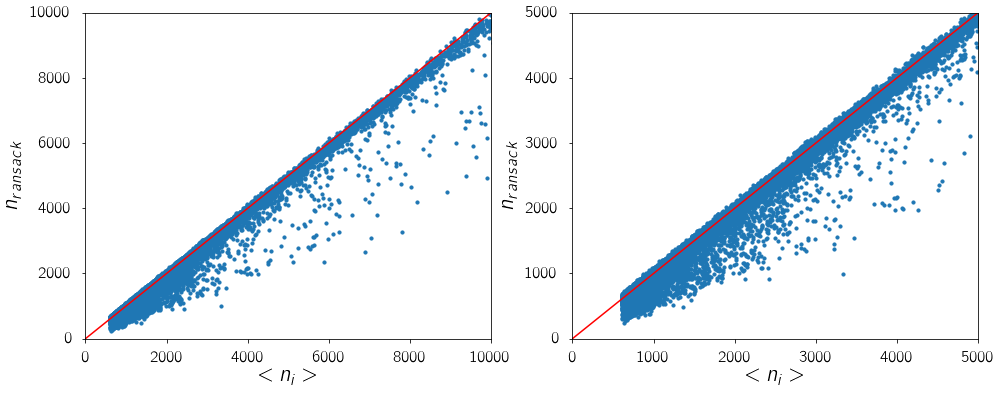

In [32]:
print('n_ransack,    n_exp*fg,    n_exp')
print('min',np.min(nc),',' ,np.min(n_exp2),',', np.min(n_exp))
print('max', np.max(nc), ',',np.max(n_exp2), ',',np.max(n_exp))
print('mean',np.mean(nc),',', np.mean(n_exp2), ',',np.mean(n_exp))
print('median',np.median(nc),',', np.median(n_exp2),',', np.median(n_exp))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16,6))

ax1.scatter(n_exp2,nc, s = 10)
ax1.plot([0,500,10000],[0,500,10000], color ='r')
ax1.set_xlim(0,10000)
ax1.set_ylim(0,10000)
ax1.set_xlabel(r'$<n_{i}>$')
ax1.set_ylabel(r'$n_{ransack}$')

ax2.scatter(n_exp2,nc, s = 10)
ax2.plot([0,500,10000],[0,500,10000], color ='r')
ax2.set_xlim(0,5000)
ax2.set_ylim(0,5000)
ax2.set_xlabel(r'$<n_{i}>$')
ax2.set_ylabel(r'$n_{ransack}$')
plt.show()

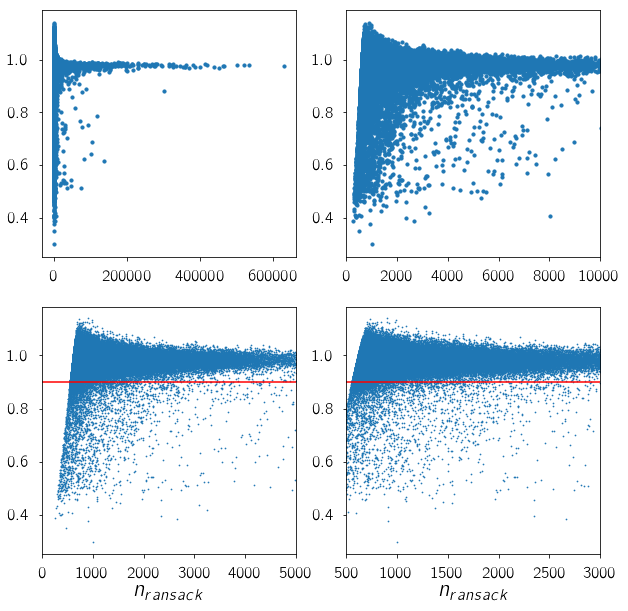

In [51]:
residue = np.asarray([nc[i]/n_exp2[i] for i in range(len(nc))])


fig, [[ax1,ax2], [ax3,ax4]] = plt.subplots(2,2, figsize=(10,10))

ax1.scatter(nc,what, s= 10)
#ax1.xlabel(r'$n_{ransack}$')
#plt.xlim(0,100)

ax2.scatter(nc,what, s = 10)
ax2.set_xlim(0,10000)
#ax2.xlabel(r'$n_{ransack}$')
ax3.scatter(nc,what, s= 0.5)
ax3.set_xlim(0,5000)
#plt.xlabel(r'$n_{ransack}$')

ax3.plot([0,100,5000],[0.9,0.9,0.9], color = 'r')
#plt.show()
ax3.set_xlabel(r'$n_{ransack}$')
ax4.scatter(nc,what, s= 0.5)
ax4.set_xlim(500,3000)
#ax4.set_xlabel(r'$n_{ransack}$')
ax4.plot([0,100,5000],[0.9,0.9,0.9], color = 'r')
ax4.set_xlabel(r'$n_{ransack}$')
plt.show()



<h2><center> And here we have our Edge-corrected sample! </center></h2>

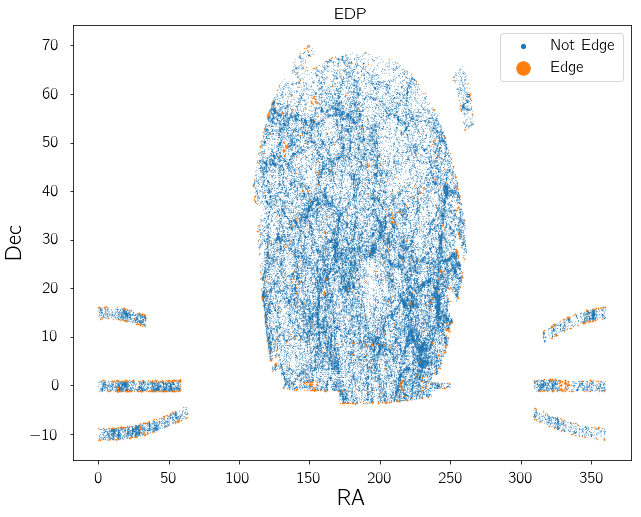

In [35]:
#Pick f_{thresh} to define the edges?
f_thresh = 0.8

thresh = np.where(nc >= f_thresh*n_exp2)[0]
below_thresh = np.where(nc <= f_thresh*n_exp2)[0]

e3 = d3[thresh]

#print(np.shape(e3))
#print(len(nc[thresh]))
#print(len(nc[below_thresh]))

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(ra[thresh], dec[thresh], s = 0.02, label = 'Not Edge')
ax.scatter(ra[below_thresh], dec[below_thresh], s = 0.2, label = 'Edge')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('EDP')
lgnd = plt.legend(loc = 1, markerscale = 30)
#plt.savefig('edge.pdf')
plt.show()

# afile = open(r'final_sample.pkl', 'wb')
# pickle.dump(e3, afile)
# afile.close()
